# Full Cell Effect of C-Rate

9/20/2020

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import yaml
import glob
import re 
from pathlib import Path
from scipy.signal import savgol_filter
from scipy import fftpack

from matplotlib import pyplot as plt
import src.plotter as plotter

import warnings
warnings.filterwarnings('ignore')

In [2]:
plotter.initialize(plt)
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)
output_path = f"{paths['outputs']}/2022-08-25-manufacturing-features"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
data_path = f'{paths["data"]}/2022-08-29-fast-formation-round-2'
file_list = sorted(Path(data_path).glob("*CHGDCH*"), key=os.path.getmtime)

file_list


[PosixPath('/Users/aweng/code/fast-formation/data/2022-08-29-fast-formation-round-2/UMBL2022FEB_CELL152074_CHGDCH_1C_P45C_5P0PSI_20220927_R1.csv'),
 PosixPath('/Users/aweng/code/fast-formation/data/2022-08-29-fast-formation-round-2/UMBL2022FEB_CELL152074_CHGDCH_C2_P45C_5P0PSI_20220927_R1.csv'),
 PosixPath('/Users/aweng/code/fast-formation/data/2022-08-29-fast-formation-round-2/UMBL2022FEB_CELL152074_CHGDCH_C4_P45C_5P0PSI_20220928_R1.csv'),
 PosixPath('/Users/aweng/code/fast-formation/data/2022-08-29-fast-formation-round-2/UMBL2022FEB_CELL152074_CHGDCH_C10_P45C_5P0PSI_20220928_R1.csv'),
 PosixPath('/Users/aweng/code/fast-formation/data/2022-08-29-fast-formation-round-2/UMBL2022FEB_CELL152074_CHGDCH_C20_P45C_5P0PSI_20220929_R1.csv'),
 PosixPath('/Users/aweng/code/fast-formation/data/2022-08-29-fast-formation-round-2/UMBL2022FEB_CELL152074_CHGDCH_C50_P45C_5P0PSI_20221001_R1.csv'),
 PosixPath('/Users/aweng/code/fast-formation/data/2022-08-29-fast-formation-round-2/UMBL2022FEB_CELL152074_CH

In [4]:
df_list = []

for file in file_list:
    df_list.append(pd.read_csv(file))

STEP_INDEX_CHARGE = 6
STEP_INDEX_DISCHARGE = 9

UMBL2022FEB_CELL152074_CHGDCH_1C_P45C_5P0PSI_20220927_R1.csv
2.21182 Ah

UMBL2022FEB_CELL152074_CHGDCH_C2_P45C_5P0PSI_20220927_R1.csv
2.37401 Ah

UMBL2022FEB_CELL152074_CHGDCH_C4_P45C_5P0PSI_20220928_R1.csv
2.44791 Ah

UMBL2022FEB_CELL152074_CHGDCH_C10_P45C_5P0PSI_20220928_R1.csv
2.49440 Ah

UMBL2022FEB_CELL152074_CHGDCH_C20_P45C_5P0PSI_20220929_R1.csv
2.50380 Ah

UMBL2022FEB_CELL152074_CHGDCH_C50_P45C_5P0PSI_20221001_R1.csv
2.52364 Ah

UMBL2022FEB_CELL152074_CHGDCH_C100_P45C_5P0PSI_20221006_R1.csv
2.52253 Ah



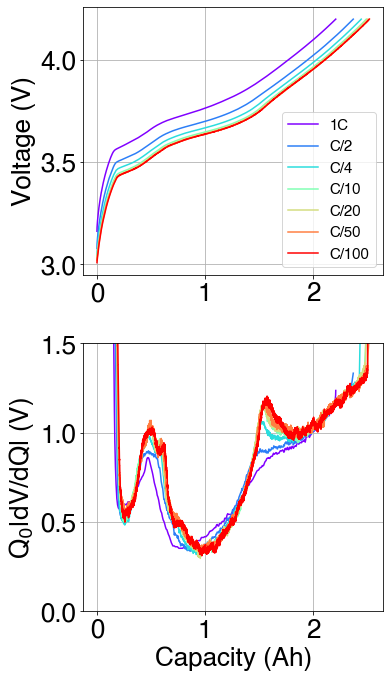

In [10]:


color = plt.cm.rainbow(np.linspace(0, 1, len(df_list)))

fh = plt.figure(figsize=(6, 10))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

c_rate_str_list = ['1C', 'C/2', 'C/4', 'C/10', 'C/20', 'C/50', 'C/100']
c_rate_array = 1/np.array([1, 2, 4, 10, 20, 50, 100])

chg_cap_array = []
chg_cap_cv_array = []
dch_cap_array = []
dch_cap_cv_array = []

for df, file, col, c_rate_str in zip(df_list, file_list, color, c_rate_str_list):
# for df, file, col in zip(reversed(df_list), reversed(file_list), reversed(color)):

    df_chg = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_CHARGE)]
    df_dch = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_DISCHARGE)]

    df_chg_cv = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_CHARGE + 1)]
    df_dch_cv = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_DISCHARGE + 1)]

    # Normalize to SOC
    # df_chg['Charge Capacity (Ah)'] /= np.max(df_chg['Charge Capacity (Ah)'])
    # df_dch['Discharge Capacity (Ah)'] /= np.max(df_dch['Discharge Capacity (Ah)'])

    xc = df_chg['Charge Capacity (Ah)']
    yc = df_chg['Potential (V)']
    
    dc = np.gradient(yc, xc) * np.max(df_chg['Charge Capacity (Ah)'])

    xd = df_dch['Discharge Capacity (Ah)']
    xd = np.max(xd) - xd
    xd = xd

    yd = df_dch['Potential (V)']
    dd = np.gradient(yd, xd) * np.max(df_dch['Discharge Capacity (Ah)'])

    ax1.plot(xc, yc, color=col, label=c_rate_str)
    ax2.plot(xc, savgol_filter(dc, int(len(dc)/80), 1), color=col)
    # ax1.plot(xd, yd, color=col)
    # ax2.plot(xd, np.abs(savgol_filter(dd, int(len(dd)/120), 1)), color=col)

    chg_cap_array.append(np.max(xc))
    chg_cap_cv_array.append(np.max(df_chg_cv['Charge Capacity (Ah)']))
    dch_cap_array.append(np.max(xd))
    dch_cap_cv_array.append(np.max(df_dch_cv['Discharge Capacity (Ah)']))
    print(file.name)
    print(f'{np.max(xc):.5f} Ah')
    print('')

ax2.set_ylim((0, 1.5))
ax2.set_xlabel('Capacity (Ah)')
ax1.legend(fontsize=15)
ax1.set_ylabel('Voltage (V)')
ax2.set_ylabel('Q$_0$|dV/dQ| (V)')

plt.tight_layout()

plt.savefig(f'{output_path}/fig_dvdq_details_full_cell_charge.png', dpi=300)


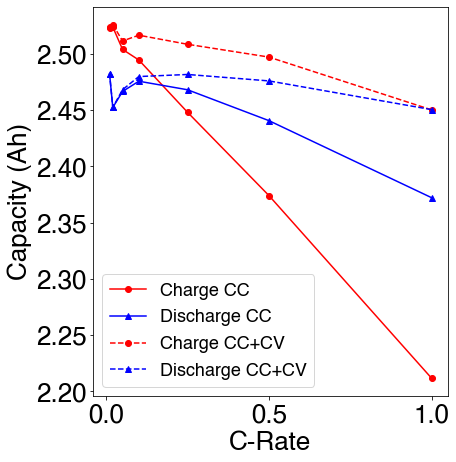

In [11]:
plt.figure(figsize=(7, 7))

plt.plot(c_rate_array, chg_cap_array, marker='o', label='Charge CC', color='r')
plt.plot(c_rate_array, dch_cap_array, marker='^', label='Discharge CC', color='b')
plt.plot(c_rate_array, chg_cap_cv_array, marker='o', label='Charge CC+CV', color='r', linestyle='--')
plt.plot(c_rate_array, dch_cap_cv_array, marker='^', label='Discharge CC+CV', color='b', linestyle='--')
plt.xlabel('C-Rate')
plt.ylabel('Capacity (Ah)')
plt.grid(False)
plt.legend(fontsize=18);

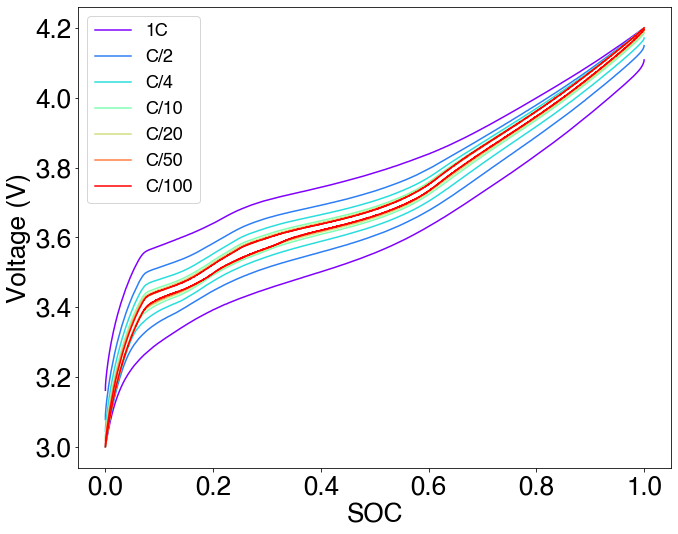

In [7]:
color = plt.cm.rainbow(np.linspace(0, 1, len(df_list)))

fh = plt.figure(figsize=(10, 8))

ax1 = plt.gca()

c_rate_str_list = ['1C', 'C/2', 'C/4', 'C/10', 'C/20', 'C/50', 'C/100']
c_rate_array = 1/np.array([1, 2, 4, 10, 20, 50, 100])

chg_cap_array = []
dch_cap_array = []

for df, file, col, c_rate_str in zip(df_list, file_list, color, c_rate_str_list):

    df_chg = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_CHARGE)]
    df_dch = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_DISCHARGE)]

    xc = df_chg['Charge Capacity (Ah)']
    xc = xc/max(xc)
    yc = df_chg['Potential (V)']
    
    xd = df_dch['Discharge Capacity (Ah)']
    xd = np.max(xd) - xd
    xd = xd
    xd = xd/max(xd)

    yd = df_dch['Potential (V)']

    ax1.plot(xc, yc, color=col, label=c_rate_str)
    ax1.plot(xd, yd, color=col)

    chg_cap_array.append(np.max(xc))
    dch_cap_array.append(np.max(xd))

ax1.legend(fontsize=18)
ax1.set_xlabel('SOC')
ax1.set_ylabel('Voltage (V)')

plt.grid(False)
plt.tight_layout()

plt.savefig(f'{output_path}/fig_dvdq_details_full_cell_normalized.png', dpi=300)
